# MCMCコードデバッグ

## import

In [1]:
import numpy as np
import scipy
import torch
import matplotlib.pyplot as plt

import ising_model as ising
import made
import mcmc_function as mcmc
import QAOA_function as qaoa

## MCMCと乱数の関係

In [2]:
seed = 1514
rng = np.random.default_rng(seed)

In [3]:
n_spin = 10
instance = ising.Ising_model(n_spin, rng, type='SK')
beta = 1.0

spin = ising.number_to_spin(0, n_spin)
for i in range(10):
	print(mcmc.uniform_update(spin, instance, beta, rng))

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 0.13663000223869526, 0)
(array([-1,  1, -1,  1, -1,  1, -1,  1, -1,  1]), 1.0, 1)
(array([-1,  1,  1,  1,  1,  1,  1, -1, -1, -1]), 1.0, 1)
(array([-1, -1, -1,  1, -1, -1, -1,  1, -1, -1]), 1.0, 1)
(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 0.18737502566028852, 0)
(array([-1, -1,  1,  1,  1,  1, -1, -1,  1,  1]), 0.3962580432381428, 1)
(array([ 1,  1, -1, -1,  1, -1, -1, -1,  1,  1]), 1.0, 1)
(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 0.0814393116070993, 0)
(array([ 1, -1, -1, -1,  1,  1,  1, -1,  1,  1]), 1.0, 1)
(array([-1, -1,  1,  1,  1,  1,  1,  1,  1,  1]), 1.0, 1)


OK!

## モデル予測の部分について

In [4]:
def predict(model, inputs: np.ndarray):
    n = model.nin
    
    # convert ndarray to torch.tensor
    inputs_th = torch.from_numpy(inputs.copy()).to(dtype=torch.float32)
    print(inputs_th.size())
    
    # apply model and sampling
    logits = model(inputs_th)
    outputs_th = torch.bernoulli(torch.sigmoid(logits))
    print(outputs_th.size())
    outputs = outputs_th.detach().numpy()
    
    return outputs

Optimization terminated successfully.
         Current function value: -3.673003
         Iterations: 40
         Function evaluations: 517
         Gradient evaluations: 47
640


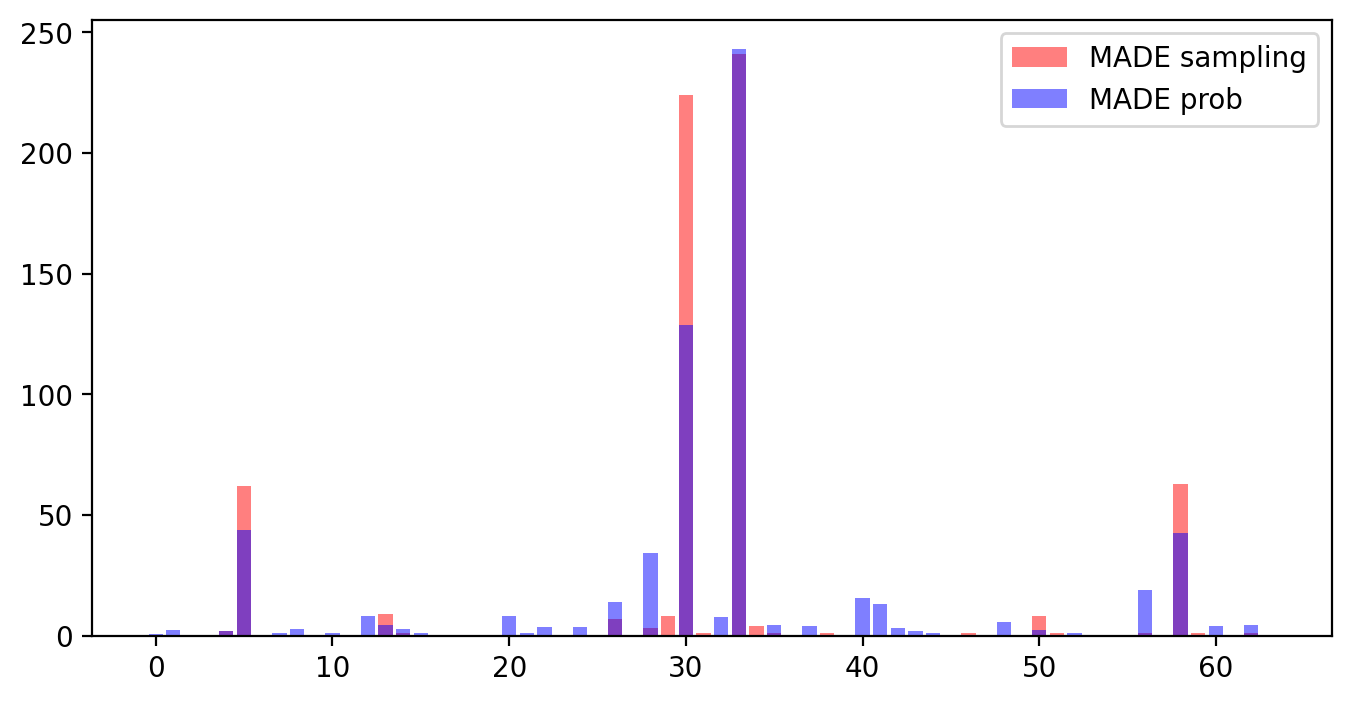

In [8]:
n_spin = 6
instance = ising.Ising_model(n_spin, rng, type='SK')

# setting
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
n_layers = 5
qaoa_ansatz = qaoa.QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def cost(para):
    return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

def callback(para):
    para_history.append(para)
    cost_history.append(cost(para))

# running QAOA
#init_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
para_history = [init_para]
cost_history = [cost(init_para)]

method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}
opt = scipy.optimize.minimize(cost, init_para, 
                              method=method,
                              callback=callback,
                              options=options)

opt_para = para_history[-1]

# sampling QAOA outputs
n_samples = 2**6
opt_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, para_history[-1], n_samples*10) # optimize parameter
opt_qaoa_data_nd = np.array([qaoa.number_to_binary(opt_qaoa_data_idx[i], n_spin) for i in range(n_samples)], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

n_test = int(0.8*n_samples)

traindata, testdata = torch.utils.data.random_split(dataset=opt_qaoa_data_nd, lengths=[n_test, n_samples-n_test])
trainset = torch.utils.data.DataLoader(traindata, batch_size=8, shuffle=False)
testset = torch.utils.data.DataLoader(testdata, batch_size=8, shuffle=True)

hidden_layers = 2
hidden_size = 2*n_spin
hidden_list = [hidden_size for i in range(hidden_layers)]
model = made.MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=45, gamma=0.1)

n_epochs = 30
train_loss, test_loss = made.run_train(model, trainset, testset, n_epochs, opt, scheduler, seed)

inputs = np.array([made.number_to_binary(rng.integers(0, 2**n_spin), n_spin) for i in range(n_samples*10)])
qaoa_pred_data_nd = made.predict(model, inputs)

qaoa_hist = np.histogram(opt_qaoa_data_idx, bins=np.arange(2**n_spin+1))

beta = 2.0
min_energy = ising.min_exact_spin_energy(instance)
boltzmann_prob = ising.spin_boltzmann_distribution(instance, beta)
boltzmann_prob_sort = np.sort(boltzmann_prob)[::-1]

all_inputs = np.array([made.number_to_binary(i, n_spin) for i in range(2**n_spin)])
pred_prob = made.compute_log_prob(model, all_inputs)
pred_prob = np.exp(pred_prob) * n_samples * 10

print(np.sum(qaoa_hist[0]))

n_top = 16
sort_idx = np.argsort(boltzmann_prob)[::-1]
fig3_3, ax3_3 = plt.subplots(figsize=(8,4), dpi=200)
#ax3_3.bar(np.arange(n_top), qaoa_hist[0][sort_idx[0:n_top]], color='red', alpha=0.5, label='MADE sampling')
#ax3_3.bar(np.arange(n_top), pred_prob[sort_idx[0:n_top]], color='blue', alpha=0.5, label='MADE prob')
ax3_3.bar(np.arange(2**n_spin), qaoa_hist[0], color='red', alpha=0.5, label='MADE sampling')
ax3_3.bar(np.arange(2**n_spin), pred_prob, color='blue', alpha=0.5, label='MADE prob')
ax3_3.legend()

In [18]:
arr = rng.integers(2, size=(10,5)).astype(dtype=np.float32)
print(arr)
print(arr.dtype)

[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 1.]
 [1. 0. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]]
float32


## 詳細釣り合いが満たされているかの確認